# setup

In [1]:
!nvidia-smi

Tue Nov 26 02:35:30 2024       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 555.42.06              Driver Version: 555.42.06      CUDA Version: 12.5     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla V100-SXM2-32GB           On  |   00000000:B2:00.0 Off |                    0 |
| N/A   32C    P0             41W /  300W |       1MiB /  32768MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [2]:
!pip install langchain langchain-huggingface bitsandbytes datasets matplotlib scikit-learn accelerate

Defaulting to user installation because normal site-packages is not writeable


In [3]:
import getpass
import os
from datasets import load_dataset

In [4]:
api_env_key = "HUGGINGFACEHUB_API_TOKEN"
if os.environ.get(api_env_key) is None:
    os.environ[api_env_key] = getpass.getpass(
        "Enter your Hugging Face API key: "
    )

Enter your Hugging Face API key:  ········


In [5]:
# Load shared utility methods
%run SharedUtils.ipynb

In [6]:
# Load LLAMA
%run LoadYi.ipynb

2024-11-26 02:35:52.653591: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-11-26 02:35:52.667360: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-11-26 02:35:52.684113: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-11-26 02:35:52.689214: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-11-26 02:35:52.701552: I tensorflow/core/platform/cpu_feature_guar

Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

7
<class 'int'>


In [7]:
dataset = load_dataset("sst2")

train_set = dataset["train"]
test_set = dataset["validation"] # using validation set as the test.

print(train_set[:5])
print(test_set[:5])

{'idx': [0, 1, 2, 3, 4], 'sentence': ['hide new secretions from the parental units ', 'contains no wit , only labored gags ', 'that loves its characters and communicates something rather beautiful about human nature ', 'remains utterly satisfied to remain the same throughout ', 'on the worst revenge-of-the-nerds clichés the filmmakers could dredge up '], 'label': [0, 0, 1, 0, 0]}
{'idx': [0, 1, 2, 3, 4], 'sentence': ["it 's a charming and often affecting journey . ", 'unflinchingly bleak and desperate ', 'allows us to hope that nolan is poised to embark a major career as a commercial yet inventive filmmaker . ', "the acting , costumes , music , cinematography and sound are all astounding given the production 's austere locales . ", "it 's slow -- very , very slow . "], 'label': [1, 0, 1, 1, 0]}


In [8]:
label_map = {
    0: "negative",
    1: "positive"
}
label_values = list(label_map.values())

train_set = train_set.map(map_labels)
test_set = test_set.map(map_labels)

X_test = test_set["sentence"]
y_test = test_set["label_human"]

print(train_set[:5])
print(test_set[:5])

{'idx': [0, 1, 2, 3, 4], 'sentence': ['hide new secretions from the parental units ', 'contains no wit , only labored gags ', 'that loves its characters and communicates something rather beautiful about human nature ', 'remains utterly satisfied to remain the same throughout ', 'on the worst revenge-of-the-nerds clichés the filmmakers could dredge up '], 'label': [0, 0, 1, 0, 0], 'label_human': ['negative', 'negative', 'positive', 'negative', 'negative']}
{'idx': [0, 1, 2, 3, 4], 'sentence': ["it 's a charming and often affecting journey . ", 'unflinchingly bleak and desperate ', 'allows us to hope that nolan is poised to embark a major career as a commercial yet inventive filmmaker . ', "the acting , costumes , music , cinematography and sound are all astounding given the production 's austere locales . ", "it 's slow -- very , very slow . "], 'label': [1, 0, 1, 1, 0], 'label_human': ['positive', 'negative', 'positive', 'positive', 'negative']}


In [9]:
def get_reasoning(label):
    reasoning_map = {
        0: "This sentence conveys dissatisfaction, criticism, or unfavorable emotions, often using words that imply negativity, disappointment, or disapproval.",
        1: "This sentence expresses favorable emotions, satisfaction, or praise, often using language that conveys positivity, happiness, or approval."
    }
    return reasoning_map.get(label)

In [10]:
few_shot_examples, examples_text, examples_text_cot = prepare_examples(train_set, key="sentence", n_per_label=1)

print(few_shot_examples)
print("---")
print(examples_text)
print("---")
print(examples_text_cot)

[{'idx': 47448, 'sentence': 'been discovered , indulged in and rejected as boring before i see this piece of crap again ', 'label': 0, 'label_human': 'negative'}, {'idx': 13189, 'sentence': 'at every opportunity to do something clever ', 'label': 1, 'label_human': 'positive'}]
---
Sentence: been discovered , indulged in and rejected as boring before i see this piece of crap again 
Sentiment: negative
Sentence: at every opportunity to do something clever 
Sentiment: positive
---
Sentence: been discovered , indulged in and rejected as boring before i see this piece of crap again 
Reasoning: This sentence conveys dissatisfaction, criticism, or unfavorable emotions, often using words that imply negativity, disappointment, or disapproval.
Sentiment: negative
Sentence: at every opportunity to do something clever 
Reasoning: This sentence expresses favorable emotions, satisfaction, or praise, often using language that conveys positivity, happiness, or approval.
Sentiment: positive


# Zero-Shot Prompting Preview

In [11]:
ai_msg = zero_shot("The food was absolutely amazing and delightful!")
print(ai_msg)
print(parse_sentiment(ai_msg))

ai_msg = zero_shot("The experience was the worst I've ever had.")
print(ai_msg)
print(parse_sentiment(ai_msg))

Starting from v4.46, the `logits` model output will have the same type as the model (except at train time, where it will always be FP32)


Your goal is to read a sentence and classify its sentiment into one of the following categories: negative, positive.

Now classify the following sentence. The output MUST follow this format:
Sentiment: [Classification]<|im_start|>user
The food was absolutely amazing and delightful!<|im_end|>
<|im_start|>assistant
Sentiment: Positive 

The text describes "food" that is "absolutely amazing and delightful." These descriptors strongly indicate a positive sentiment towards
positive
Your goal is to read a sentence and classify its sentiment into one of the following categories: negative, positive.

Now classify the following sentence. The output MUST follow this format:
Sentiment: [Classification]<|im_start|>user
The experience was the worst I've ever had.<|im_end|>
<|im_start|>assistant
Sentiment: Negative 

I used the definition that the sentiment should be classified as either negative or positive based on the overall mood conveyed by
negative


# Few-Shot Prompting Preview

In [12]:
ai_msg = few_shot("The food was absolutely amazing and delightful!", examples_text)
print(ai_msg)
print(parse_sentiment(ai_msg))

ai_msg = few_shot("The experience was the worst I've ever had.", examples_text)
print(ai_msg)
print(parse_sentiment(ai_msg))

Your goal is to read a sentence and classify its sentiment into one of the following categories: negative, positive.

Here are some examples:
Sentence: been discovered , indulged in and rejected as boring before i see this piece of crap again 
Sentiment: negative
Sentence: at every opportunity to do something clever 
Sentiment: positive

Now classify the following sentence. The output MUST follow this format:
Sentiment: [Classification]<|im_start|>user
The food was absolutely amazing and delightful!<|im_end|>
<|im_start|>assistant
Sentiment: positive teacher Here's an example of using the given definition to classify the sentiment of an input sentence:

Input: I
positive
Your goal is to read a sentence and classify its sentiment into one of the following categories: negative, positive.

Here are some examples:
Sentence: been discovered , indulged in and rejected as boring before i see this piece of crap again 
Sentiment: negative
Sentence: at every opportunity to do something clever 
S

# Few-Shot with Chain-of-Thought Preview

In [13]:
ai_msg = few_shot("The food was absolutely amazing and delightful!", examples_text_cot)
print(ai_msg)
print(parse_sentiment(ai_msg))

ai_msg = few_shot("The experience was the worst I've ever had.", examples_text_cot)
print(ai_msg)
print(parse_sentiment(ai_msg))

Your goal is to read a sentence and classify its sentiment into one of the following categories: negative, positive.

Here are some examples:
Sentence: been discovered , indulged in and rejected as boring before i see this piece of crap again 
Reasoning: This sentence conveys dissatisfaction, criticism, or unfavorable emotions, often using words that imply negativity, disappointment, or disapproval.
Sentiment: negative
Sentence: at every opportunity to do something clever 
Reasoning: This sentence expresses favorable emotions, satisfaction, or praise, often using language that conveys positivity, happiness, or approval.
Sentiment: positive

Now classify the following sentence. The output MUST follow this format:
Sentiment: [Classification]<|im_start|>user
The food was absolutely amazing and delightful!<|im_end|>
<|im_start|>assistant
Sentiment: positive 2021-06-18 09:23:54
User uploaded a file:
positive
Your goal is to read a sentence and classify its sentiment into one of the followin

# Zero-Shot Evaluation

In [14]:
# sampleset = test_set.select(range(100))

In [15]:
zero_shot_results = evaluate_model(X_test, y_test, zero_shot, None)

You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset


---
Sentence: why make a documentary about these marginal historical figures ? 
True: negative
Prediction: negative
Processed 100/872 examples, Time: 117.719
---

---
Sentence: at the very least , if you do n't know anything about derrida when you walk into the theater , you wo n't know much more when you leave . 
True: negative
Prediction: negative
Processed 200/872 examples, Time: 235.361
---

---
Sentence: the sort of film that makes me miss hitchcock , but also feel optimistic that there 's hope for popular cinema yet . 
True: positive
Prediction: positive
Processed 300/872 examples, Time: 353.118
---

---
Sentence: if director michael dowse only superficially understands his characters , he does n't hold them in contempt . 
True: negative
Prediction: positive
Processed 400/872 examples, Time: 470.744
---

---
Sentence: unlike the speedy wham-bam effect of most hollywood offerings , character development -- and more importantly , character empathy -- is at the heart of italian for 

Filtered 11 invalid predictions.
Accuracy: 91.6376
              precision    recall  f1-score   support

    negative       0.93      0.90      0.91       422
    positive       0.91      0.93      0.92       439

    accuracy                           0.92       861
   macro avg       0.92      0.92      0.92       861
weighted avg       0.92      0.92      0.92       861



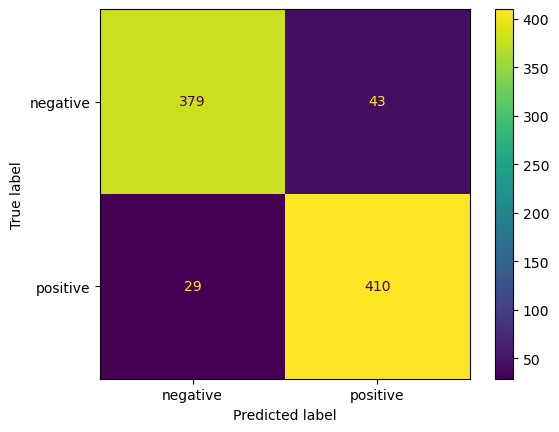

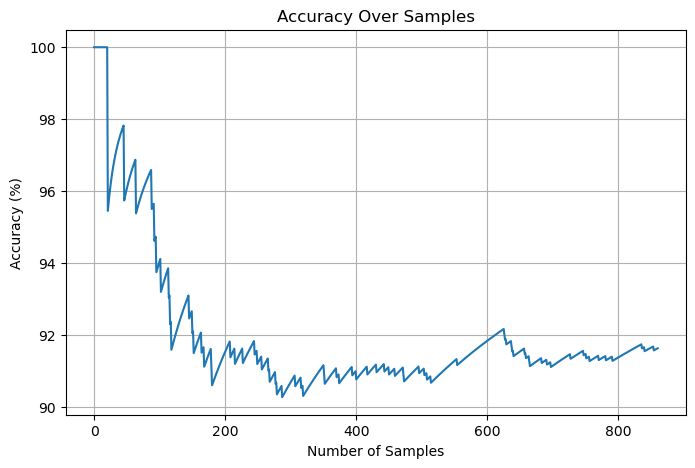

In [16]:
create_reports(y_test, zero_shot_results)

# Few-Shot Evaluation

In [17]:
few_shot_results = evaluate_model(X_test, y_test, few_shot, examples_text)

---
Sentence: why make a documentary about these marginal historical figures ? 
True: negative
Prediction: invalid
Processed 100/872 examples, Time: 123.905
---

---
Sentence: at the very least , if you do n't know anything about derrida when you walk into the theater , you wo n't know much more when you leave . 
True: negative
Prediction: negative
Processed 200/872 examples, Time: 247.752
---

---
Sentence: the sort of film that makes me miss hitchcock , but also feel optimistic that there 's hope for popular cinema yet . 
True: positive
Prediction: positive
Processed 300/872 examples, Time: 371.715
---

---
Sentence: if director michael dowse only superficially understands his characters , he does n't hold them in contempt . 
True: negative
Prediction: positive
Processed 400/872 examples, Time: 495.342
---

---
Sentence: unlike the speedy wham-bam effect of most hollywood offerings , character development -- and more importantly , character empathy -- is at the heart of italian for b

Filtered 44 invalid predictions.
Accuracy: 93.5990
              precision    recall  f1-score   support

    negative       0.92      0.95      0.93       391
    positive       0.95      0.93      0.94       437

    accuracy                           0.94       828
   macro avg       0.94      0.94      0.94       828
weighted avg       0.94      0.94      0.94       828



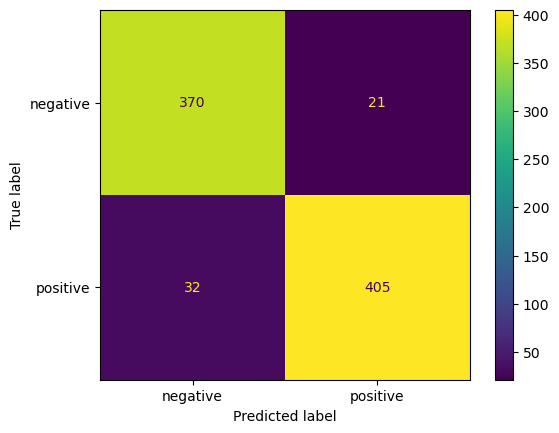

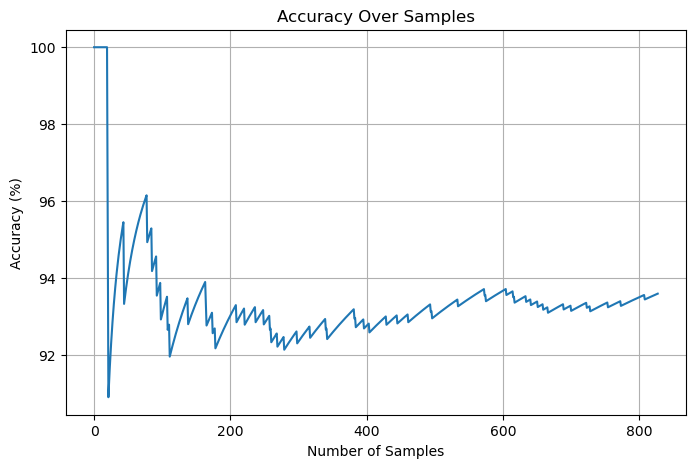

In [18]:
create_reports(y_test, few_shot_results)

# Few-Shot Chain-of-Thought Evaluation

In [19]:
few_shot_cot_results = evaluate_model(X_test, y_test, few_shot, examples_text_cot)

---
Sentence: why make a documentary about these marginal historical figures ? 
True: negative
Prediction: negative
Processed 100/872 examples, Time: 132.700
---

---
Sentence: at the very least , if you do n't know anything about derrida when you walk into the theater , you wo n't know much more when you leave . 
True: negative
Prediction: negative
Processed 200/872 examples, Time: 265.454
---

---
Sentence: the sort of film that makes me miss hitchcock , but also feel optimistic that there 's hope for popular cinema yet . 
True: positive
Prediction: invalid
Processed 300/872 examples, Time: 398.159
---

---
Sentence: if director michael dowse only superficially understands his characters , he does n't hold them in contempt . 
True: negative
Prediction: negative
Processed 400/872 examples, Time: 530.894
---

---
Sentence: unlike the speedy wham-bam effect of most hollywood offerings , character development -- and more importantly , character empathy -- is at the heart of italian for b

Filtered 45 invalid predictions.
Accuracy: 93.4704
              precision    recall  f1-score   support

    negative       0.90      0.97      0.94       407
    positive       0.97      0.90      0.93       420

    accuracy                           0.93       827
   macro avg       0.94      0.94      0.93       827
weighted avg       0.94      0.93      0.93       827



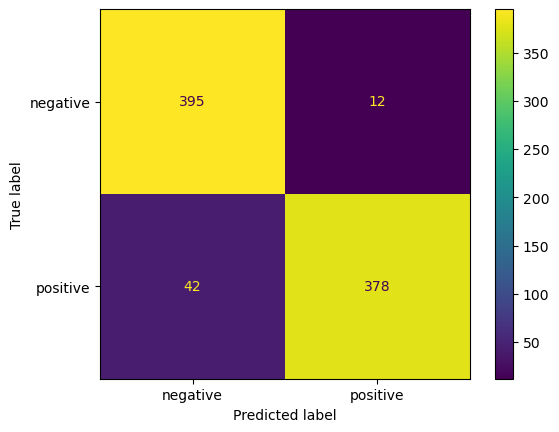

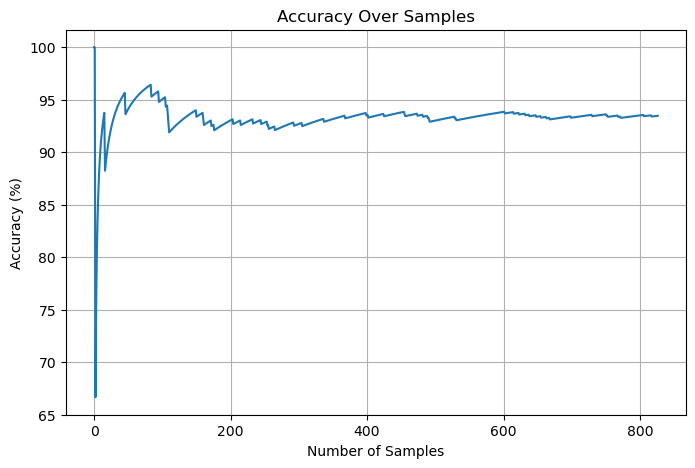

In [20]:
create_reports(y_test, few_shot_cot_results)